# Proyecto 1 NLP – Clasificación supervisada

**Universidad del Valle de Guatemala**  
**Facultad de Ingeniería**  
**Departamento de Ciencias de la Computación**  
**Procesamiento de Lenguaje Natural**   

## Integrantes: 
- Pablo Orellana
- Diego Leiva
- Renatto Guzmán

## Librerías

In [1]:
import pandas as pd
import re, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SpanishStemmer
import nltk
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.sparse import hstack, coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

## 1. Preprocesamiento del Corpus

### Cargar Corpus

Corpus obtenido de Kaggle en: [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish)

In [2]:
df = pd.read_csv('Data/IMDB Dataset SPANISH.csv')
print(f"=== Dataset ===")
print(f"Documentos: {df.shape[0]}")
print(f"Características: {df.shape[1]}\n")
print("=== Información del Dataset ===")
df.info()
print("\n=== Primeras 5 filas del Dataset ===")
df.head()

=== Dataset ===
Documentos: 50000
Características: 5

=== Información del Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   50000 non-null  int64 
 1   review_en    50000 non-null  object
 2   review_es    50000 non-null  object
 3   sentiment    50000 non-null  object
 4   sentimiento  50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB

=== Primeras 5 filas del Dataset ===


,Unnamed: 0,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo


### Procesamiento de DataFrame

In [3]:
# Eliminar columnas en ingles o innecesarias
df = df.drop(columns=['review_en', 'Unnamed: 0', 'sentiment'])

# Renombrar columnas
df = df.rename(columns={'review_es': 'review'})

# Convertir variable objetivo a binaria
df['sentimiento'] = df['sentimiento'].map({'positivo': 1, 'negativo': 0})

# Eliminar duplicados
df = df.drop_duplicates()

# Eliminar filas con valores nulos
df = df.dropna()

print(f"=== Dataset Procesado ===")
print(f"Documentos: {df.shape[0]}")
print(f"Características: {df.shape[1]}\n")
print("\n=== Primeras 5 filas del Dataset ===")
df.head()

=== Dataset Procesado ===
Documentos: 49599
Características: 2


=== Primeras 5 filas del Dataset ===


,review,sentimiento
0,Uno de los otros críticos ha mencionado que de...,1
1,Una pequeña pequeña producción.La técnica de f...,1
2,Pensé que esta era una manera maravillosa de p...,1
3,"Básicamente, hay una familia donde un niño peq...",0
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


### Normalización de Texto

In [4]:
def limpiar_texto(texto: str) -> str:
    """
    Función para limpiar y normalizar texto en español.
    Parámetros:
        texto (str): Texto a limpiar.
    Retorna:
        str: Texto limpio y normalizado.
    """
    # 1) a minúsculas
    s = str(texto).lower().strip()
    # 2) quitar tildes/diacríticos
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    # 3) remover URLs, emails, @usuarios, #hashtags
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)
    s = re.sub(r'\S+@\S+\.\S+', ' ', s)
    s = re.sub(r'[@#]\w+', ' ', s)
    # 4) quitar puntuación y símbolos
    s = re.sub(r'[^\w\s]', ' ', s, flags=re.UNICODE)  # elimina ¡¿, comas, puntos, comillas, etc.
    s = re.sub(r'_', ' ', s)
    # 5) espacios múltiples a uno
    s = re.sub(r'\s+', ' ', s)
    # 6) eliminar numeros
    s = re.sub(r'\d+', ' ', s)
    return s.strip()

In [5]:
# Crear columna normalizada
df["review_norm"] = df["review"].apply(limpiar_texto)

# Mostrar ejemplos de limpieza
print("Ejemplo (antes y después):\n")
for i in range(5):
    print(f"- Original: {df['review'].iloc[i][:50]}...")
    print(f"- Limpia  : {df['review_norm'].iloc[i][:50]}...\n")

# Verificar si hay vacios después de la limpieza
vacios = df['review_norm'].str.strip().eq('')
print(f"Número de filas con texto vacío después de la limpieza: {vacios.sum()}")
# Eliminar filas con texto vacío
df = df[~vacios]
print(f"Filas restantes después de eliminar textos vacíos: {df.shape[0]}")

Ejemplo (antes y después):

- Original: Uno de los otros críticos ha mencionado que despué...
- Limpia  : uno de los otros criticos ha mencionado que despue...

- Original: Una pequeña pequeña producción.La técnica de filma...
- Limpia  : una pequena pequena produccion la tecnica de filma...

- Original: Pensé que esta era una manera maravillosa de pasar...
- Limpia  : pense que esta era una manera maravillosa de pasar...

- Original: Básicamente, hay una familia donde un niño pequeño...
- Limpia  : basicamente hay una familia donde un nino pequeno ...

- Original: El "amor en el tiempo" de Petter Mattei es una pel...
- Limpia  : el amor en el tiempo de petter mattei es una pelic...

Número de filas con texto vacío después de la limpieza: 0
Filas restantes después de eliminar textos vacíos: 49599


### Stopwords
Se amplian las stopwords de NTLK con el conjunto de stopwords de [alir3z4 Stop Words](https://alir3z4.github.io/stop-words/)

In [6]:
def normalize(s: str) -> str:
    """
    Normaliza una cadena de texto, convirtiéndola a minúsculas, eliminando tildes y espacios en blanco.
    Parámetros:
        s (str): Cadena de texto a normalizar.
    Retorna:
        str: Cadena de texto normalizada.
    """
    s = s.lower().strip()
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def norm_set(words):
    """
    Normaliza un conjunto de palabras.
    Parámetros:
        words (iterable): Conjunto de palabras a normalizar.
    Retorna:
        set: Conjunto de palabras normalizadas.
    """
    return {normalize(w) for w in words if w.strip()}

In [7]:
# Descargar stopwords de NLTK si no se han descargado
nltk.download('stopwords', quiet=True)

# 1) base y extras
sw_es = set(stopwords.words('spanish'))
sw_en = set(stopwords.words('english'))

# Agregar stopwords comunes en español e inglés extra
with open("Data/spanish_stopwords.txt", encoding="utf-8") as f:
    es_extra = {ln.strip() for ln in f if ln.strip()}
with open("Data/english_stopwords.txt", encoding="utf-8") as f:
    en_extra = {ln.strip() for ln in f if ln.strip()}

# 2) protegidas
negaciones = {
    "no","nunca","jamas","ni","sin","tampoco","ningun",
    "ninguna","ninguno","ningunas","ningunos","nadie","nada"
    }
contrastivos = {
    "pero","aunque","sin","embargo","sinembargo","no",
    "obstante","sino","excepto","salvo","aunquesi"
    }
intensif = {"muy","tan","tanto","tantos","tantas",
            "demasiado","demasiada","demasiados",
            "demasiadas","super","re","hiper","bastante",
            "apenas","poco","poca","pocos","pocas","casi",
            "algo","sumamente"
            }

protegidas = norm_set(negaciones | contrastivos | intensif)

# 3) normalizar todo
sw_total_norm = norm_set(sw_es|es_extra|sw_en|en_extra) - protegidas
print("=== Resumen de stopwords ===")
print(f"Stopwords español base: {len(sw_es)} | extra: {len(es_extra)}")
print(f"Stopwords inglés base: {len(sw_en)} | extra: {len(en_extra)}")
print(f"Stopwords finales: {len(sw_total_norm)}")

# 4) regex con bordes de palabra
pattern = re.compile(r'\b(?:' + '|'.join(sorted(map(re.escape, sw_total_norm), key=len, reverse=True)) + r')\b')

# 5) aplicar a la columna ya normalizada
df["review_sin_sw"] = (
    df["review_norm"]
      .str.replace(pattern, " ", regex=True)
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
)

# Chequeo rápido
print("\nEjemplos (antes y sin stopwords):\n")
for i in range(5):
    print(f"- Reseña        : {df['review_norm'].iloc[i][:50]}...")
    print(f"- Sin Stopwords : {df['review_sin_sw'].iloc[i][:50]}...\n")

# Verificar si hay vacios después de remover stopwords
vacios_sw = df['review_sin_sw'].str.strip().eq('')
print(f"Número de filas con texto vacío después de remover stopwords: {vacios_sw.sum()}")
# Eliminar filas con texto vacío
df = df[~vacios_sw]
print(f"Filas restantes después de eliminar textos vacíos: {df.shape[0]}")

=== Resumen de stopwords ===
Stopwords español base: 313 | extra: 608
Stopwords inglés base: 198 | extra: 1298
Stopwords finales: 1844

Ejemplos (antes y sin stopwords):

- Reseña        : uno de los otros criticos ha mencionado que despue...
- Sin Stopwords : criticos mencionado oz episodio enganchado razon e...

- Reseña        : una pequena pequena produccion la tecnica de filma...
- Sin Stopwords : pequena pequena produccion tecnica filmacion muy i...

- Reseña        : pense que esta era una manera maravillosa de pasar...
- Sin Stopwords : pense maravillosa pasar semana verano demasiado ca...

- Reseña        : basicamente hay una familia donde un nino pequeno ...
- Sin Stopwords : basicamente familia nino pequeno jake piensa zombi...

- Reseña        : el amor en el tiempo de petter mattei es una pelic...
- Sin Stopwords : amor petter mattei pelicula visualmente impresiona...

Número de filas con texto vacío después de remover stopwords: 0
Filas restantes después de eliminar text

### Tokenización y Stemming

In [8]:
# Descargar recursos de NLTK si no se han descargado
nltk.download('punkt', quiet=True)

# Inicializar el stemmer en español
stemmer = SpanishStemmer()

# Aplicar stemming a la columna sin stopwords
# tokens crudos (sin stopwords)
df["tokens"] = df["review_sin_sw"].apply(lambda x: word_tokenize(x, language="spanish"))

# tokens stem (lista)
df["tokens_stem"] = df["tokens"].apply(lambda xs: [stemmer.stem(t) for t in xs])

df.head()

,review,sentimiento,review_norm,review_sin_sw,tokens,tokens_stem
0,Uno de los otros críticos ha mencionado que de...,1,uno de los otros criticos ha mencionado que de...,criticos mencionado oz episodio enganchado raz...,"[criticos, mencionado, oz, episodio, enganchad...","[critic, mencion, oz, episodi, enganch, razon,..."
1,Una pequeña pequeña producción.La técnica de f...,1,una pequena pequena produccion la tecnica de f...,pequena pequena produccion tecnica filmacion m...,"[pequena, pequena, produccion, tecnica, filmac...","[pequen, pequen, produccion, tecnic, filmacion..."
2,Pensé que esta era una manera maravillosa de p...,1,pense que esta era una manera maravillosa de p...,pense maravillosa pasar semana verano demasiad...,"[pense, maravillosa, pasar, semana, verano, de...","[pens, maravill, pas, seman, veran, demasi, ca..."
3,"Básicamente, hay una familia donde un niño peq...",0,basicamente hay una familia donde un nino pequ...,basicamente familia nino pequeno jake piensa z...,"[basicamente, familia, nino, pequeno, jake, pi...","[basic, famili, nin, pequen, jak, piens, zombi..."
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1,el amor en el tiempo de petter mattei es una p...,amor petter mattei pelicula visualmente impres...,"[amor, petter, mattei, pelicula, visualmente, ...","[amor, pett, mattei, pelicul, visual, impresio..."


### Levenshtein
No se aplica a todo el dataset debido a que:
- El corpus tiene ~50 000 reseñas → millones de palabras únicas.
- Comparar cada palabra con todas las demás sería $(O(n^2))$, ineficiente y sin valor práctico.

In [9]:
def levenshtein(a: str, b: str) -> int:
    """
    Distancia de edición mínima entre a y b.
    
    Parámetros:
        a (str): Primera cadena.
        b (str): Segunda cadena.
    Retorna:
        int: Distancia de edición mínima.
        """
    if a == b:
        return 0
    if not a:
        return len(b)
    if not b:
        return len(a)
    dp = np.zeros((len(a)+1, len(b)+1), dtype=int)
    dp[0, :] = np.arange(len(b)+1)
    dp[:, 0] = np.arange(len(a)+1)
    for i in range(1, len(a)+1):
        for j in range(1, len(b)+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i, j] = min(dp[i-1, j]+1, dp[i, j-1]+1, dp[i-1, j-1]+cost)
    return dp[len(a), len(b)]

In [10]:
# Construcción del vocabulario
# Tomamos los tokens sin stem para detectar errores reales
vocab_counts = Counter(t for toks in df["tokens"] for t in toks)
print(f"Vocabulario total: {len(vocab_counts)} palabras")

# Palabras frecuentes (consideradas válidas)
freq_words = {w for w, c in vocab_counts.items() if c >= 5}

# Ejemplo de corrección
palabra = "exelente"
distancias = {w: levenshtein(palabra, w) for w in list(freq_words)[:2000]}  # comparar con un subconjunto
sugerencia = min(distancias, key=distancias.get)
print(f"Palabra: {palabra} → Sugerencia más cercana: {sugerencia}")

# Opcional: aplicar a todo el vocabulario raro (<3 apariciones)
rare = {w for w, c in vocab_counts.items() if c < 3}
correcciones = {}
for w in list(rare)[:20]:
    candidatos = {v: levenshtein(w, v) for v in freq_words if abs(len(v)-len(w)) <= 2}
    if candidatos:
        best = min(candidatos, key=candidatos.get)
        if candidatos[best] <= 1:
            correcciones[w] = best

print("\nEjemplos de correcciones detectadas:")
for k, v in list(correcciones.items())[:10]:
    print(f"{k} → {v}")

Vocabulario total: 168396 palabras
Palabra: exelente → Sugerencia más cercana: regente

Ejemplos de correcciones detectadas:
lovant → levant
kathhryn → kathryn
mattau → mathau
adopten → adoptan
apetit → petit
myddleton → middleton
librias → libras
aproximar → aproxima
obsesione → obsesiono


## 2. Representación del Texto

### Bolsa de Palabras (BoW) y TF-IDF

In [11]:
# Crear reseñas con "stems" para vectorizadores basados en conteo
df["text_stem"] = df["tokens_stem"].apply(lambda xs: " ".join(xs))

# Aplicar BoW y TF-IDF
bow_vec = CountVectorizer(min_df=5, max_df=0.5, ngram_range=(1,2))   # unigrams+bigramas
tfidf_vec = TfidfVectorizer(min_df=5, max_df=0.5, ngram_range=(1,2), sublinear_tf=True)

# Transformar
X_bow   = bow_vec.fit_transform(df["text_stem"])
X_tfidf = tfidf_vec.fit_transform(df["text_stem"])

print("=== BoW ===")
print(f"Documentos: {X_bow.shape[0]}")
print(f"Términos distintos: {X_bow.shape[1]}")
print(f"Densidad promedio: {X_bow.nnz / (X_bow.shape[0]*X_bow.shape[1]):.6f}")
print(f"Entradas no nulas (nnz): {X_bow.nnz:,}")
print(f"Promedio de términos no nulos por documento: {X_bow.nnz / X_bow.shape[0]:.1f}\n")

print("=== TF-IDF ===")
print(f"Documentos: {X_tfidf.shape[0]}")
print(f"Términos distintos: {X_tfidf.shape[1]}")
print(f"Densidad promedio: {X_tfidf.nnz / (X_tfidf.shape[0]*X_tfidf.shape[1]):.6f}")
print(f"Entradas no nulas (nnz): {X_tfidf.nnz:,}")
print(f"Promedio de términos no nulos por documento: {X_tfidf.nnz / X_tfidf.shape[0]:.1f}")

=== BoW ===
Documentos: 49599
Términos distintos: 151860
Densidad promedio: 0.000777
Entradas no nulas (nnz): 5,854,820
Promedio de términos no nulos por documento: 118.0

=== TF-IDF ===
Documentos: 49599
Términos distintos: 151860
Densidad promedio: 0.000777
Entradas no nulas (nnz): 5,854,820
Promedio de términos no nulos por documento: 118.0


### Matriz de co-ocurrencia y aplicación de PPMI

In [12]:
# Limitar a vocabulario top-V para controlar memoria
V = 10000  # Solo 10k palabras más frecuentes
# Obtener mas frecuentes
freq = Counter(t for toks in df["tokens"] for t in toks).most_common(V)
itos = [w for w,_ in freq]
stoi = {w:i for i,w in enumerate(itos)}

# Contar co-ocurrencias en ventana
window = 4     # contexto a cada lado
pair_counts = defaultdict(int)

# Iterar sobre tokens y contar pares
for toks in df["tokens"]:
    # obtener índices de vocabulario
    idxs = [stoi[t] for t in toks if t in stoi]
    # contar pares en ventana
    for i, wi in enumerate(idxs):
        j0 = max(0, i-window) # inicio de ventana
        j1 = min(len(idxs), i+window+1) # fin de ventana
        # contar pares
        for j in range(j0, j1):
            if j == i: 
                continue
            wj = idxs[j]
            if wi == wj: 
                continue
            # conteo simétrico
            a,b = (wi,wj) if wi < wj else (wj,wi)
            pair_counts[(a,b)] += 1 

# Construir matriz simétrica COO
rows, cols, data = [], [], [] # listas para COO

# llenar listas
for (i,j), c in pair_counts.items():
    rows += [i, j]
    cols += [j, i]
    data += [c, c]
# Crear matriz dispersa COO
C = coo_matrix((data, (rows, cols)), shape=(V, V), dtype=np.float64).tocsr()
total = C.sum() # suma total de co-ocurrencias

# Calcular PPMI
# PMI(i,j) = log2( P(i,j) / (P(i)P(j)) ), PPMI = max(PMI, 0)
row_sums = np.asarray(C.sum(axis=1)).ravel()
col_sums = row_sums  # simétrica
C_coo = C.tocoo()
p_ij = C_coo.data / total
p_i  = row_sums[C_coo.row] / total
p_j  = col_sums[C_coo.col] / total
pmi  = np.log2((p_ij / (p_i * p_j)) + 1e-12)
ppmi_data = np.maximum(pmi, 0.0)

# Crear matriz PPMI dispersa
PPMI = coo_matrix((ppmi_data, (C_coo.row, C_coo.col)), shape=C.shape).tocsr()
print("=== MATRIZ DE CO-OCURRENCIA ===")
print(f"Dimensión: {C.shape}")
print(f"Entradas no nulas (nnz): {C.nnz:,}")
print(f"Densidad: {C.nnz / (C.shape[0]*C.shape[1]):.8f}")
print(f"Total de co-ocurrencias contadas: {int(total):,}")
print(f"Media de conteo por par no nulo: {C.data.mean():.2f}")

print("\n=== MATRIZ PPMI ===")
print(f"Dimensión: {PPMI.shape}")
print(f"Entradas no nulas (nnz): {PPMI.nnz:,}")
print(f"Densidad: {PPMI.nnz / (PPMI.shape[0]*PPMI.shape[1]):.8f}")
print(f"Valor medio PPMI (>0): {PPMI.data.mean():.4f}")
print(f"Valor máximo PPMI: {PPMI.data.max():.4f}")

=== MATRIZ DE CO-OCURRENCIA ===
Dimensión: (10000, 10000)
Entradas no nulas (nnz): 11,637,960
Densidad: 0.11637960
Total de co-ocurrencias contadas: 65,419,004
Media de conteo por par no nulo: 5.62

=== MATRIZ PPMI ===
Dimensión: (10000, 10000)
Entradas no nulas (nnz): 11,637,960
Densidad: 0.11637960
Valor medio PPMI (>0): 2.0399
Valor máximo PPMI: 12.4341


### Implementación de embeddings con Word2Vec

In [13]:
# Preparar datos para Word2Vec/FastText
sentences = df["tokens"].tolist()

# Word2Vec con skip-gram
w2v = Word2Vec(
    sentences=sentences, 
    vector_size=100, 
    window=5, 
    min_count=5, 
    workers=4, 
    sg=1, 
    negative=10, 
    epochs=5
    )

# Vectores de documento por promedio de palabras presentes
def doc_vector(tokens, kv):
    vecs = [kv[w] for w in tokens if w in kv]
    if not vecs:
        return np.zeros(kv.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0)

doc_vecs_w2v = np.vstack([doc_vector(toks, w2v.wv) for toks in sentences])
palabras_ejemplo = ["bueno", "malo", "excelente", "terrible", "divertido", "aburrido"]

# Mostrar dimendiones y ejemplos
print("=== Word2Vec ===")
print(f"Tamaño del vocabulario w2v: {len(w2v.wv)}")
print(f"Dimensiones de los vectores w2v: {w2v.wv.vectors.shape[1]}")
print("Ejemplos: ")
for w in palabras_ejemplo:
    if w in w2v.wv:
        print(f"Similares a '{w}':", [p for p,_ in w2v.wv.most_similar(w)[:5]])
    else:
        print(f"{w}: No en vocabulario")

=== Word2Vec ===
Tamaño del vocabulario w2v: 51380
Dimensiones de los vectores w2v: 100
Ejemplos: 
bueno: No en vocabulario
Similares a 'malo': ['risiblemente', 'risamente', 'ristiable', 'tycus', 'redimiendo']
Similares a 'excelente': ['excepcional', 'estupenda', 'fantastica', 'sobresaliente', 'maravilloso']
Similares a 'terrible': ['horrible', 'atroz', 'horrenda', 'execrable', 'atrocada']
Similares a 'divertido': ['humoristico', 'entretenido', 'hilarante', 'gracioso', 'sketismo']
Similares a 'aburrido': ['tedioso', 'hackneado', 'rutinario', 'inconexado', 'ploding']


### Comparación mediante PCA o t-SNE

In [14]:
def plot_pca(X: np.ndarray, words: list, title: str) -> None:
    """
    Visualiza vectores en 2D usando PCA.
    Parámetros:
        X: Matriz de vectores (n_samples, n_features)
        words: Lista de palabras correspondientes a los vectores
        title: Título del gráfico
    Retorna: 
        None
    """
    pca = PCA(n_components=2, random_state=0)
    X2 = pca.fit_transform(X)
    plt.figure(figsize=(8,6))
    plt.scatter(X2[:,0], X2[:,1], s=8)
    for i,w in enumerate(words[:60]):  # anota pocas
        plt.annotate(w, (X2[i,0], X2[i,1]), fontsize=8)
    plt.title(title)
    plt.show()

def plot_tsne(X: np.ndarray, words: list, title: str, n: int = 200) -> None:
    """
    Visualiza vectores en 2D usando t-SNE.
    Parámetros:
        X: Matriz de vectores (n_samples, n_features)
        words: Lista de palabras correspondientes a los vectores
        title: Título del gráfico
        n: Número de muestras a visualizar
    Retorna: 
        None
    """
    Xs = X[:n]; ws = words[:n]
    tsne = TSNE(n_components=2, init="random", perplexity=30,
                learning_rate="auto", max_iter=1000, random_state=0)
    X2 = tsne.fit_transform(Xs)
    plt.figure(figsize=(8,6))
    plt.scatter(X2[:,0], X2[:,1], s=8)
    for i,w in enumerate(ws[:50]):
        plt.annotate(w, (X2[i,0], X2[i,1]), fontsize=8)
    plt.title(title)
    plt.show()

Palabras comunes usadas: 300


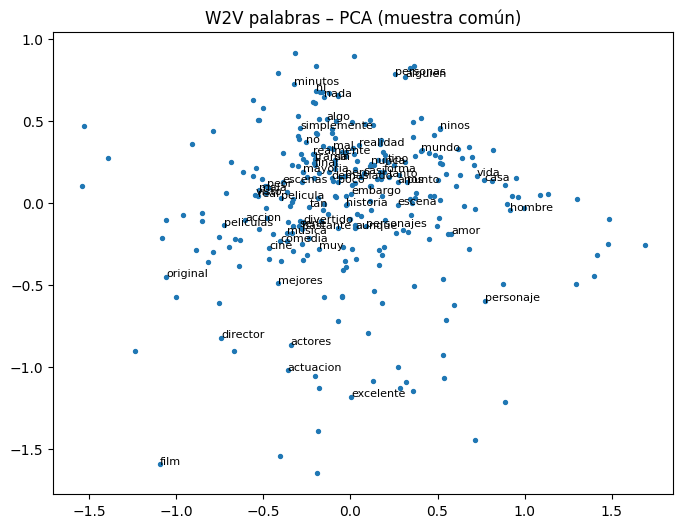

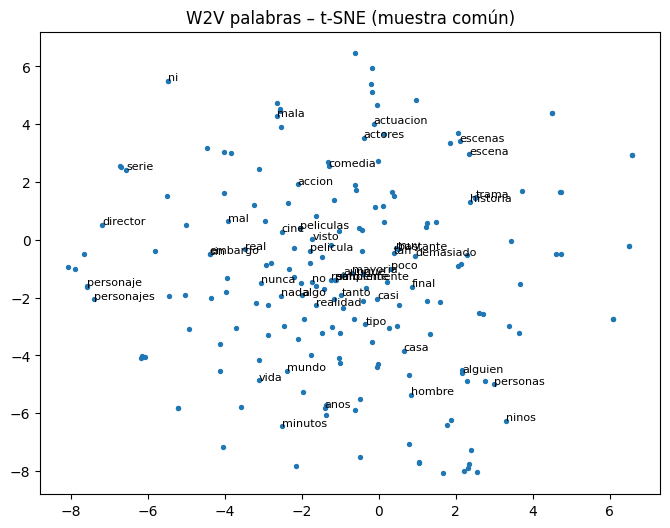

In [15]:
# === Selección de palabras comunes para comparar W2V vs FastText ===
K = 300  # muestra
cand = [w for w,_ in freq]  # freq ya calculado antes
common = [w for w in cand if (w in w2v.wv.key_to_index)]
words = common[:K]
print(f"Palabras comunes usadas: {len(words)}")

# === Matrices de vectores ===
X_w2v = np.vstack([w2v.wv[w] for w in words])

# === W2V: PCA y t-SNE ===
plot_pca(X_w2v, words, "W2V palabras – PCA (muestra común)")
plot_tsne(X_w2v, words, "W2V palabras – t-SNE (muestra común)")

## 3. Modelos Probabilísticos

### Modelo de lenguaje N-gramas

In [16]:
def add_bounds(s: list) -> list:
    """
    Agrega tokens de inicio y fin a una secuencia.
    Parámetros:
        s: lista de tokens (palabras)
    Retorna:
        list: secuencia con tokens de inicio y fin añadidos.
    """
    return ["<s>"] + s + ["</s>"]

def map_unk(s: list, vocab: set) -> list:
    """
    Mapea palabras fuera del vocabulario a <unk>.
    Parámetros:
        s: lista de tokens (palabras)
        vocab: conjunto de palabras en el vocabulario
    Retorna:
        list: secuencia con palabras fuera del vocabulario reemplazadas por <unk>.
    """
    return [w if w in vocab else "<unk>" for w in s]

def ngrams(seq: list, n: int):
    """
    Generador de n-gramas a partir de una secuencia.
    Parámetros:
        seq: lista de tokens (palabras)
        n: tamaño del n-grama
    Retorna:
        generator: generador de tuplas de n-gramas
    """
    for i in range(len(seq)-n+1):
        yield tuple(seq[i:i+n])

def build_ngram_counts(sents: list, n: int) -> tuple:
    """
    Construye contadores de n-gramas a partir de una lista de oraciones.
    Parámetros:
        sents: lista de oraciones (cada una es una lista de tokens)
        n: tamaño del n-grama
    Retorna:
        tuple: dos contadores (counts_n, counts_n1) para n-gramas y (n-1)-gramas
    """
    counts_n = Counter()
    counts_n1 = Counter()
    for s in sents:
        counts_n.update(ngrams(s, n))
        if n > 1:
            counts_n1.update(ngrams(s, n-1))
    return counts_n, counts_n1

In [19]:
# Usa tokens SIN stemming
random.seed(0)
sentences = [t for t in df["tokens"].tolist() if t]  # lista de listas
random.shuffle(sentences)
split = int(0.8*len(sentences))
train_sents = sentences[:split]
test_sents  = sentences[split:]

# Agregar tokens de inicio y fin
train_sents = [add_bounds(s) for s in train_sents]
test_sents  = [add_bounds(s) for s in test_sents]

# UNK por rareza (mejor estabilidad)
unigram_counts_tmp = Counter(w for s in train_sents for w in s)
UNK_THRESH = 2
vocab = {w for w,c in unigram_counts_tmp.items() if c >= UNK_THRESH} | {"<s>","</s>","<unk>"}

# Mapear a <unk>
train_sents = [map_unk(s, vocab) for s in train_sents]
test_sents  = [map_unk(s, vocab) for s in test_sents]

# Bigramas y trigramas
bi_counts, uni_counts = build_ngram_counts(train_sents, 2)
tri_counts, bi_counts_tri = build_ngram_counts(train_sents, 3)  # para trigramas
V = len(vocab)

print("=== N-gramas (entrenamiento) ===")
print(f"Vocab: {V}")
print(f"Unigramas: {len(uni_counts):,}")
print(f"Bigramas: {len(bi_counts):,}")
print(f"Trigramas: {len(tri_counts):,}")

=== N-gramas (entrenamiento) ===
Vocab: 80242
Unigramas: 80,242
Bigramas: 2,507,851
Trigramas: 3,872,405


# Smoothing Add-k

In [20]:
def prob_addk(history: list, w: str, counts_n: Counter, counts_h: Counter, k: float = 1.0) -> float:
    """
    Calcula la probabilidad de un n-grama con suavizado aditivo.
    Parámetros:
        history: lista de palabras que forman el historial (n-1 palabras)
        w: palabra objetivo
        counts_n: contador de n-gramas
        counts_h: contador de (n-1)-gramas
        k: parámetro de suavizado (default=1.0)
    Retorna:
        float: probabilidad suavizada P(w | history)
    """
    # history y n-grama deben concordar
    h_count = counts_h.get(tuple(history), 0)
    hw_count = counts_n.get(tuple(list(history)+[w]), 0)
    return (hw_count + k) / (h_count + k*V)

### Kneser-Ney

In [21]:
# P_continuation(w) = #hist únicos que preceden a w / #bigram types
cont_predecessors = defaultdict(set)
for (h,w), c in bi_counts.items():
    cont_predecessors[w].add(h)
N_bigram_types = len(bi_counts)
P_cont = {w: len(pre)/N_bigram_types for w,pre in cont_predecessors.items()}

# N1+(h,*) = #palabras distintas que siguen a h
N1_h = Counter()
followers = defaultdict(set)
for (h,w), c in bi_counts.items():
    followers[h].add(w)
for h, s in followers.items():
    N1_h[h] = len(s)

D = 0.75  # descuento típico

In [22]:
def prob_kn_bigram(h: str, w: str) -> float:
    """
    Calcula la probabilidad de un bigrama usando suavizado Kneser-Ney.
    Parámetros:
        h: palabra en la historia
        w: palabra objetivo
    Retorna:
        float: probabilidad P(w | h) con Kneser-Ney
    """
    h = tuple([h])  # historia de 1 palabra
    c_hw = bi_counts.get((h[0], w), 0)
    c_h  = uni_counts.get(h[0], 0)
    if c_h == 0:
        # backoff total a continuación
        return P_cont.get(w, 1.0/V)
    first = max(c_hw - D, 0) / c_h if c_h > 0 else 0.0
    lam = (D * N1_h.get(h[0], 0)) / c_h if c_h > 0 else 1.0
    return first + lam * P_cont.get(w, 1.0/V)

### Entropía y perplejidad

In [23]:
def sent_logprob_addk(sent: list[str], n=2, k=1.0) -> tuple[float, int]:
    """
    Calcula el logaritmo de la probabilidad de una oración usando un modelo n-grama con suavizado aditivo.
    Parámetros:
        sent: lista de tokens (palabras) en la oración
        n: tamaño del n-grama (2 para bigrama, 3 para trigrama)
        k: parámetro de suavizado (default=1.0)
    Retorna:
        tuple: (log_probabilidad, número_de_tokens)
    """
    s = sent
    logp = 0.0
    count_tokens = 0
    # n-gramas según n
    if n == 2:
        # bigramas
        for (h,w) in ngrams(s, 2):
            p = prob_addk([h], w, bi_counts, uni_counts, k)
            logp += math.log(p+1e-12)
            count_tokens += 1
    elif n == 3:
        # trigramas
        for (h1,h2,w) in ngrams(s, 3):
            p = prob_addk([h1,h2], w, tri_counts, bi_counts_tri, k)
            logp += math.log(p+1e-12)
            count_tokens += 1
    return logp, count_tokens

def sent_logprob_kn_bigram(sent: list[str]) -> tuple[float, int]:
    """
    Calcula el logaritmo de la probabilidad de una oración usando un modelo de bigramas con suavizado Kneser-Ney.
    Parámetros:
        sent: lista de tokens (palabras) en la oración
    Retorna:
        tuple: (log_probabilidad, número_de_tokens)
    """
    s = sent
    logp = 0.0
    count_tokens = 0
    # Iterar sobre bigramas
    for (h,w) in ngrams(s, 2):
        p = prob_kn_bigram(h, w)
        logp += math.log(p+1e-12)
        count_tokens += 1
    return logp, count_tokens

def corpus_entropy_perplexity(test_sents: list[list[str]], mode="addk_bigram", k=0.1) -> tuple[float, float, int]:
    """
    Calcula la entropía y perplejidad de un corpus de prueba usando un modelo n-grama.
    Parámetros:
        test_sents: lista de oraciones (cada una es una lista de tokens)
        mode: tipo de modelo ("addk_bigram", "addk_trigram", "kn_bigram")
        k: parámetro de suavizado aditivo (solo para "addk_*")
    Retorna:
        tuple: (entropía en bits por token, perplejidad, número total de tokens)
    """
    total_logp = 0.0
    total_tokens = 0
    # iterar sobre oraciones
    for s in test_sents:
        if mode == "addk_bigram":
            lp, n = sent_logprob_addk(s, n=2, k=k)
        elif mode == "addk_trigram":
            lp, n = sent_logprob_addk(s, n=3, k=k)
        elif mode == "kn_bigram":
            lp, n = sent_logprob_kn_bigram(s)
        else:
            raise ValueError("modo desconocido")
        total_logp += lp
        total_tokens += n
    # entropía en bits por token, perplejidad
    H = - total_logp / total_tokens / math.log(2)
    PP = 2 ** H
    return H, PP, total_tokens

In [24]:
print("\n=== Entropía / Perplejidad ===")
H_bi_k01, PP_bi_k01, Ntok = corpus_entropy_perplexity(test_sents, "addk_bigram", k=0.1)
H_tri_k01, PP_tri_k01, _   = corpus_entropy_perplexity(test_sents, "addk_trigram", k=0.1)
H_kn, PP_kn, _             = corpus_entropy_perplexity(test_sents, "kn_bigram")

print(f"Tokens evaluados: {Ntok:,}")
print(f"Bigram Add-k (k=0.1)  -> H={H_bi_k01:.3f} bits,  PP={PP_bi_k01:.2f}")
print(f"Trigram Add-k (k=0.1) -> H={H_tri_k01:.3f} bits,  PP={PP_tri_k01:.2f}")
print(f"Bigram Kneser-Ney     -> H={H_kn:.3f} bits,  PP={PP_kn:.2f}")


=== Entropía / Perplejidad ===
Tokens evaluados: 1,044,505
Bigram Add-k (k=0.1)  -> H=13.450 bits,  PP=11191.71
Trigram Add-k (k=0.1) -> H=15.849 bits,  PP=59040.98
Bigram Kneser-Ney     -> H=12.642 bits,  PP=6389.73


### Ejemplos de probabilidad de oraciones

In [27]:
def sent_prob_report(text_tokens: list[str], vocab: set[str]) -> None:
    """
    Reporta la entropía y perplejidad de una oración dada usando varios modelos n-grama.
    Parámetros:
        text_tokens: lista de tokens (palabras) en la oración
        vocab: conjunto de palabras en el vocabulario
    Retorna:
        None
    """
    # mapear a <unk> y agregar límites
    s = add_bounds(map_unk(text_tokens, vocab))
    lp_bi, n_bi = sent_logprob_addk(s, n=2, k=0.1)
    lp_tri, n_tri = sent_logprob_addk(s, n=3, k=0.1)
    lp_kn, n_kn = sent_logprob_kn_bigram(s)
    # convertir a bits y perplejidad
    def to_bits(lp, n): 
        H = -lp/n/math.log(2); PP = 2**H; return H, PP
    # calcular entropía y perplejidad
    Hb, PPb = to_bits(lp_bi, n_bi); Ht, PPt = to_bits(lp_tri, n_tri); Hk, PPk = to_bits(lp_kn, n_kn)
    # reporte
    print("\n--- Oración:", " ".join(text_tokens))
    print(f"Bigram Add-k H={Hb:.3f}, PP={PPb:.2f}")
    print(f"Trigram Add-k H={Ht:.3f}, PP={PPt:.2f}")
    print(f"Bigram KN     H={Hk:.3f}, PP={PPk:.2f}")

In [29]:
# Ejemplos
sent_prob_report(["la","pelicula","fue","excelente"], vocab)
sent_prob_report(["la","trama","resulto","aburrida"], vocab)


--- Oración: la pelicula fue excelente
Bigram Add-k H=7.458, PP=175.80
Trigram Add-k H=11.322, PP=2559.64
Bigram KN     H=7.799, PP=222.76

--- Oración: la trama resulto aburrida
Bigram Add-k H=10.409, PP=1359.84
Trigram Add-k H=16.310, PP=81252.76
Bigram KN     H=10.115, PP=1109.24
